In [2]:
import matplotlib
import loadnotebook
from helper import * 

importing Jupyter notebook from helper.ipynb


In [4]:
#len(result.groupby(result.filename).size())

helper.ipynb:713: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  "\n",


total point :  291
[ 37  40  39  38  42  41 247]


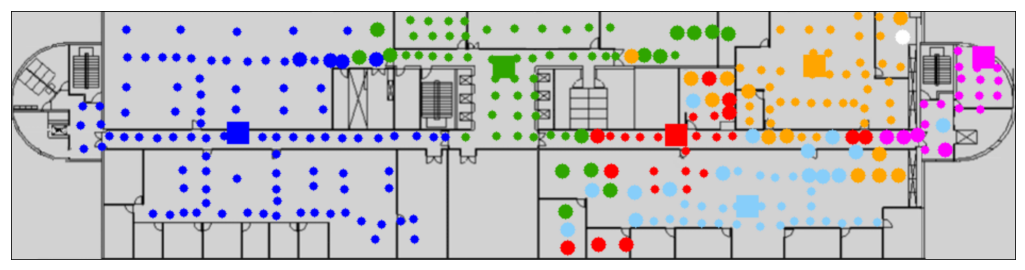

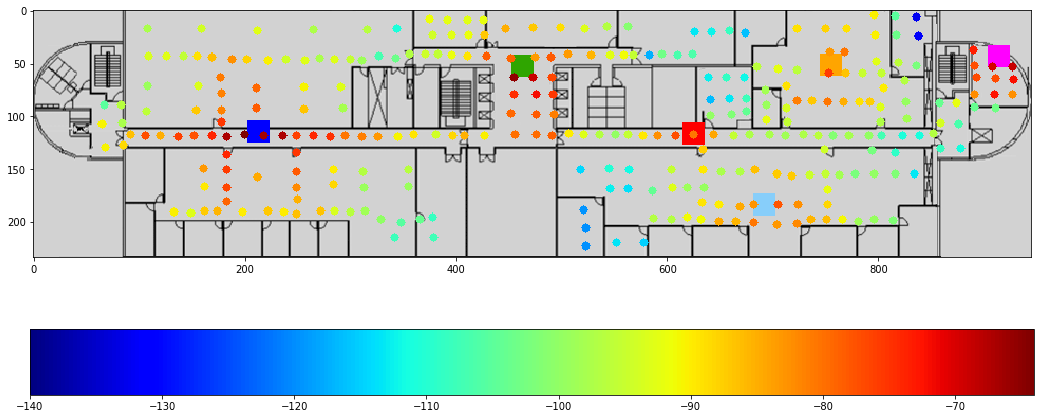

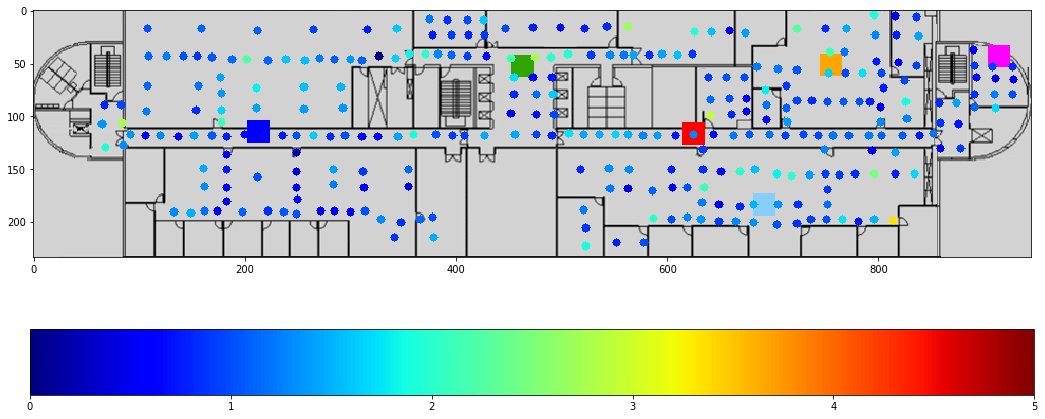

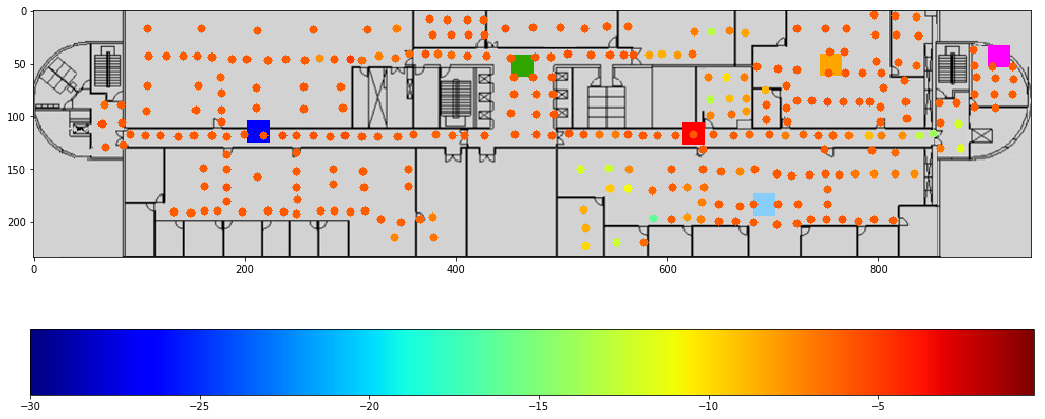

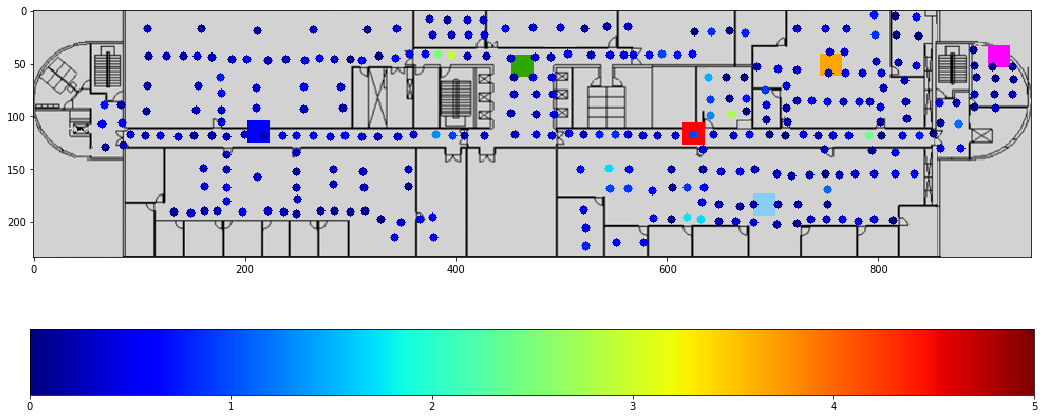

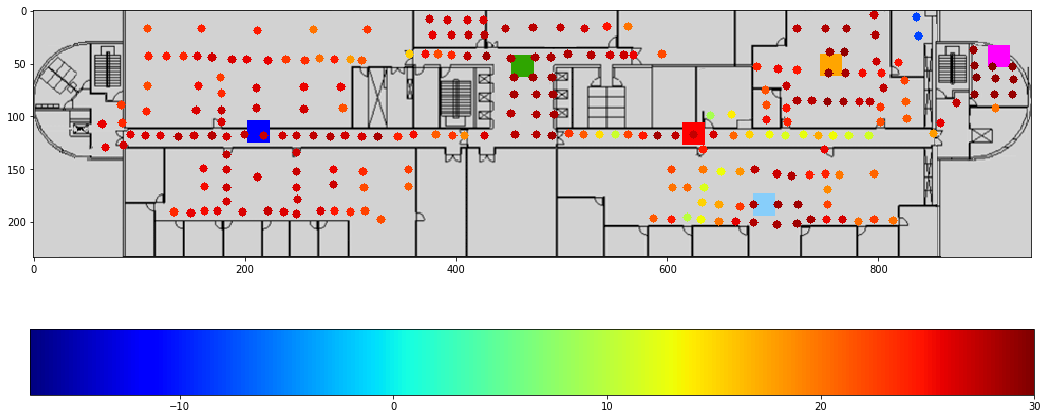

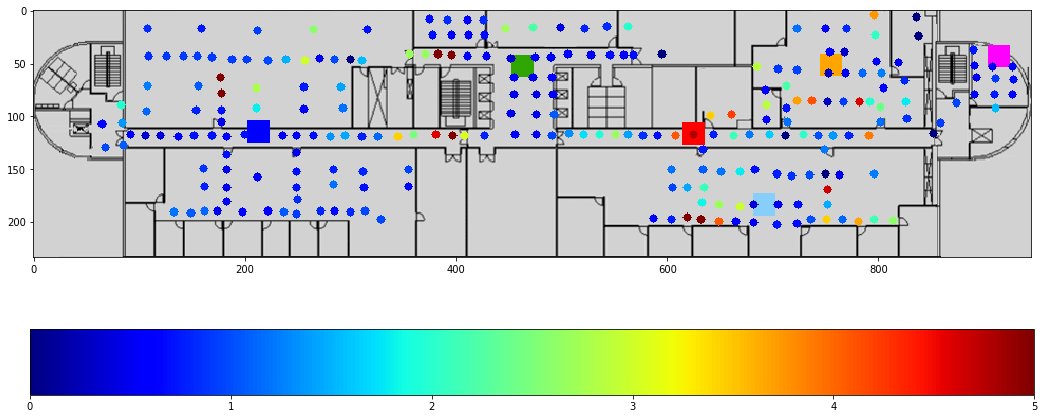

In [5]:
#Check the priority and set first
#And modify whitelist in helper
#lock_pci and pci_locker are for single pci map

priority = 6
set_value = 2

#Set lock_pci = True, if you want to show the map for one specific pci
#And the pci_locker is which pci you want 

lock_pci=False
pci_locker=302

#to check is there a missing point we need to regather

expected_total_point = 219
source = get_source(priority, set_value)

#make sure there is the correct path for file to put in

if lock_pci and pci_locker in whitelist_PCI:
    output_csv = "../results/demo_priority_" + str(priority) + "/set" + str(set_value)+"-"+str(pci_locker) + ".csv"
else:
    output_csv = "../results/demo_priority_" + str(priority) + "/set" + str(set_value) + ".csv"
    
    

def get_output_image(prefix="") :
    if lock_pci and pci_locker in whitelist_PCI:
        return "../results/demo_priority_" + str(priority) + "/images/set" + \
            str(set_value) +"/"+str(pci_locker)+ "_" + prefix + ".png"
    else:
        return "../results/demo_priority_" + str(priority) + "/images/set" + \
            str(set_value) + "_" + prefix + ".png"

    
#if you need the feature in csv, set feature = True(it takes more time)
result = extract_data(config={priority : [set_value]}, feature=False, pure=False)
if set_value != 1  and priority == 6 :
    total_point = len(result.groupby(["location_x", "location_y"]).agg(['count']))
    print("total point : ", total_point)

# because set 1 we have't rename the folder based on location number
# this block only work for priority 6 set > 2
    if total_point < expected_total_point:
        d = {}
        source = get_source(priority, set_value)
        filenames, _ = get_filenames(source)
        for f in filenames : 
            d[int(f.split("/")[-2])]=f
        
        missing_point = []
        arr = np.arange(expected_total_point)
        for a in arr :
            if a not in d:
                if a < 211 or a > 282:
                    missing_point.append(a)
    
        print("number of missing point : ",expected_total_point-total_point)
        print("missing point : ", missing_point)

#LOCK THE PCI

if lock_pci and pci_locker in whitelist_PCI:
    filter = result["PCI"] == pci_locker
    result_old=result
    result=result[filter]

#trans result to csv

result.to_csv(output_csv, index=False)

#PCI MAP

df = result.dropna(subset=["PCI"])
lon_list = df["location_x"].astype('int32')
lat_list = df["location_y"].astype('int32')
pci_list = df["PCI"].astype('int32')
print(df.PCI.unique())

new_format=True
new_backtorgb = get_map_image(new_format=new_format)

pci_color = [pci_color_dict[x] if x in pci_color_dict else (255, 255, 255) for x in pci_list]

#
pci_summary = summary_based_on_location_for_pci(lat_list, lon_list, pci_list)
#structure: {lat: {lon: {pci: weight}
#pci_summary = summary_dict(pci_summary, np.array)


new_backtorgb = visualize2(new_backtorgb, lon_list, lat_list, pci_color, 
                          get_output_image("pci"), adjustment=new_format)

#PCI Interference Map

df = result.dropna(subset=["PCI"])
lon_list = df["location_x"].astype('int32')
lat_list = df["location_y"].astype('int32')
pci_list = df["PCI"].astype('int32')
print(df.PCI.unique())

new_format=True
new_backtorgb = get_map_image(new_format=new_format)

pci_summary = summary_based_on_location_for_pci(lat_list, lon_list, pci_list)
#structure: {lat: {lon: {pci: weight}
pci_summary = reweight_dict(pci_summary, np.array)
#structure: {lat: {lon: {pci: ln(weight)}
x_list, y_list, pci_list, weight_list = summary_dict_to_list_pci(pci_summary)
pci_color = [pci_color_dict[x] if x in pci_color_dict else (255, 255, 255) for x in pci_list]


new_backtorgb = visualize_pci(new_backtorgb, x_list, y_list, weight_list, pci_color, 
                          get_output_image("pci_interference"), adjustment=new_format)

#RSRP Location Map

df = result.dropna(subset=["RSRQ"])
lon_list = df["location_x"].astype('int32')
lat_list = df["location_y"].astype('int32')
rsrp_list = df["RSRP"].astype('int32')
pci_list = df["PCI"].astype('int32')

rsrp_summary = summary_based_on_location2(lat_list, lon_list, pci_list, rsrp_list)
rsrp_summary = summary_dict2(rsrp_summary, np.array)
rsrp_summary = filtering_dict(rsrp_summary, np.array)

#RSRP Location Map_mean

normalize_rsrp_mean = matplotlib.colors.Normalize(vmin=-140, vmax=-64)
rsrp_mean = summary_dict2(rsrp_summary, np.mean)
x_list, y_list, rsrp_mean_list = summary_dict_to_list(rsrp_mean)
colors_rsrp_mean = [cmap(normalize_rsrp_mean(value))[:3] for value in rsrp_mean_list]
colors_rsrp_mean = [[int(x*255) for x in value] for value in colors_rsrp_mean]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_rsrp_mean, 
                               cmap, normalize_rsrp_mean, get_output_image("rsrp_mean"))

#RSRP Location Map_std

normalize_rsrp_std = matplotlib.colors.Normalize(vmin=0, vmax=5)
rsrp_std = summary_dict2(rsrp_summary, np.std)
x_list, y_list, rsrp_std_list = summary_dict_to_list(rsrp_std)
colors_rsrp_std = [cmap(normalize_rsrp_std(value))[:3] for value in rsrp_std_list]
colors_rsrp_std = [[int(x*255) for x in value] for value in colors_rsrp_std]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_rsrp_std, 
                               cmap, normalize_rsrp_std, get_output_image("rsrp_std"))

#RSRQ Location Map

df = result.dropna(subset=["RSRQ"])
lon_list = df["location_x"].astype('int32')
lat_list = df["location_y"].astype('int32')
rsrq_list = df["RSRQ"].astype('int32')
pci_list = df["PCI"].astype('int32')

rsrq_summary = summary_based_on_location2(lat_list, lon_list, pci_list, rsrq_list)
rsrq_summary = summary_dict2(rsrq_summary, np.array)

#RSRQ Location Map_mean

normalize_rsrq_mean = matplotlib.colors.Normalize(vmin=-30, vmax=-0.4)
rsrq_mean = summary_dict2(rsrq_summary, np.mean)
x_list, y_list, rsrq_mean_list = summary_dict_to_list(rsrq_mean)
colors_rsrq_mean = [cmap(normalize_rsrq_mean(value))[:3] for value in rsrq_mean_list]
colors_rsrq_mean = [[int(x*255) for x in value] for value in colors_rsrq_mean]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_rsrq_mean,
                               cmap, normalize_rsrq_mean, get_output_image("rsrq_mean"))

#RSRQ Location Map_std

normalize_rsrq_std = matplotlib.colors.Normalize(vmin=0, vmax=5)
rsrq_std = summary_dict2(rsrq_summary, np.std)
x_list, y_list, rsrq_std_list = summary_dict_to_list(rsrq_std)
colors_rsrq_std = [cmap(normalize_rsrq_std(value))[:3] for value in rsrq_std_list]
colors_rsrq_std = [[int(x*255) for x in value] for value in colors_rsrq_std]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_rsrq_std,
                               cmap, normalize_rsrq_std, get_output_image("rsrq_std"))

#SNR Location Map

df = result.dropna(subset=["SNR"])
lon_list = df["location_x"].astype('int32')
lat_list = df["location_y"].astype('int32')
snr_list = df["SNR"].astype('int32')
pci_list = df["PCI"].astype('int32')

snr_summary = summary_based_on_location2(lat_list, lon_list, pci_list, snr_list)
snr_summary = summary_dict2(snr_summary, np.array)

#SNR Location Map_mean

normalize_snr_mean = matplotlib.colors.Normalize(vmin=-17, vmax=30)
snr_mean = summary_dict2(snr_summary, np.mean)
x_list, y_list, snr_mean_list = summary_dict_to_list(snr_mean)
colors_snr_mean = [cmap(normalize_snr_mean(value))[:3] for value in snr_mean_list]
colors_snr_mean = [[int(x*255) for x in value] for value in colors_snr_mean]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_snr_mean,
                               cmap, normalize_snr_mean, get_output_image("snr_mean"))

#SNR Location Map_std

normalize_snr_std = matplotlib.colors.Normalize(vmin=0, vmax=5)
snr_std = summary_dict2(snr_summary, np.std)
x_list, y_list, snr_std_list = summary_dict_to_list(snr_std)
colors_snr_std = [cmap(normalize_snr_std(value))[:3] for value in snr_std_list]
colors_snr_std = [[int(x*255) for x in value] for value in colors_snr_std]

new_backtorgb = get_map_image()
new_backtorgb = visualize_cmap(new_backtorgb, x_list, y_list, colors_snr_std, 
                               cmap, normalize_snr_std, get_output_image("snr_std"))